In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import cv2
import tensorflow as tf
import os
import os
import random
import shutil
import sys
import shutil
import csv
from PIL import Image
import matplotlib.patches as mpatches
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_predict
import math
import seaborn as sns
from sklearn.model_selection import KFold

In [135]:
N1 = 69225 % 2
N1

1

In [136]:
N1 = 699531 % 2
N1

1

### Calculando a área da Celula

In [137]:
def calculaAreaPerimetroImagem(img_cv2):
  
  imagem_cinza = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2GRAY)
  _, mascara_binaria = cv2.threshold(imagem_cinza, 1, 255, cv2.THRESH_BINARY)
  contornos, _ = cv2.findContours(mascara_binaria, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  mascara_colorida = np.zeros_like(img_cv2)
  cv2.drawContours(mascara_colorida, contornos, -1, (255, 255, 255), thickness=cv2.FILLED)

  # Exibir a imagem original, a máscara e a parte colorida
  area_branca = np.sum(mascara_binaria == 255)
  
  
  total_perimetro = 0
  
  for contorno in contornos:
    perimeter = cv2.arcLength(contorno, closed=True)
    total_perimetro += perimeter
  
  return area_branca, round(total_perimetro, 2)


### Calculando Compacidade

In [138]:
# perimetro^2 / 4 PI area
def calcularCompacidade(img_cv2):
  area, perimetro = calculaAreaPerimetroImagem(img_cv2)
  
  compacidade = (perimetro**2) / (area * (4 * math.pi)) 
  
  return round(compacidade, 4)

### Calculando Excentricidade

In [146]:
def calcularExcentricidades(img_cv2):
  
  imagem_cinza = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2GRAY)
  _, mascara_binaria = cv2.threshold(imagem_cinza, 1, 255, cv2.THRESH_BINARY)
  contornos, _ = cv2.findContours(mascara_binaria, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  maior_contorno = max(contornos, key=cv2.contourArea)

    
  if len(maior_contorno) >= 5:
    # (elipse_x, elipse_y), (eixo_maior, eixo_menor), _ = cv2.fitEllipse(maior_contorno)
    elipse = cv2.fitEllipse(maior_contorno)
    eixo_maior = max(elipse[1])
    eixo_menor = min(elipse[1])
    # Restante do seu código
  else:
    return 0


  # Calcular excentricidade
  # 1-menor^2 / 1-maior^2
  
  excentricidade = 1 - ((eixo_menor ** 2) / (eixo_maior ** 2))
  
  # if(eixo_maior != 0 and eixo_menor != 0):
  #   value_mid = round((eixo_menor / eixo_maior)**2, 2)
  # else:
  #   return 0
  
  # excentricidade = round(np.sqrt(value_mid-1),2)
  
  return excentricidade

### Gerar CSV

In [147]:
csv = {'id_cel': [],
       'label': [],
       'area': [],
       'compacidade': [],
       'excentricidade': [],
       }

path_dataset_segmentation = "./data/segmentation_dataset/"


for pasta_atual, subpastas, arquivos in os.walk(path_dataset_segmentation):
    for arquivo in arquivos:
        caminho_completo = os.path.join(pasta_atual, arquivo)
        
        imagem = cv2.imread(caminho_completo)
        
        
        area, _ = calculaAreaPerimetroImagem(imagem)
        
        nomeSplit = caminho_completo.split("\\")
        classeSpli = nomeSplit[0].split("/")
        nomeCel = nomeSplit[1].replace(".png", "")
        nomeClasse = classeSpli[len(classeSpli)-1]
        csv['id_cel'].append(nomeCel)

        
        csv['area'].append(round(area,2))
        csv['label'].append(nomeClasse)
        csv['compacidade'].append(calcularCompacidade(imagem))
        csv['excentricidade'].append(calcularExcentricidades(imagem))
          
  
       
df = pd.DataFrame(csv)
df.to_csv('csv_pt2.csv', index=False)       


In [48]:
df = pd.read_csv("csv_pt2.csv")

### Gerando scatterplot com as caracteristicas calculadas

#### Area X Compacidade

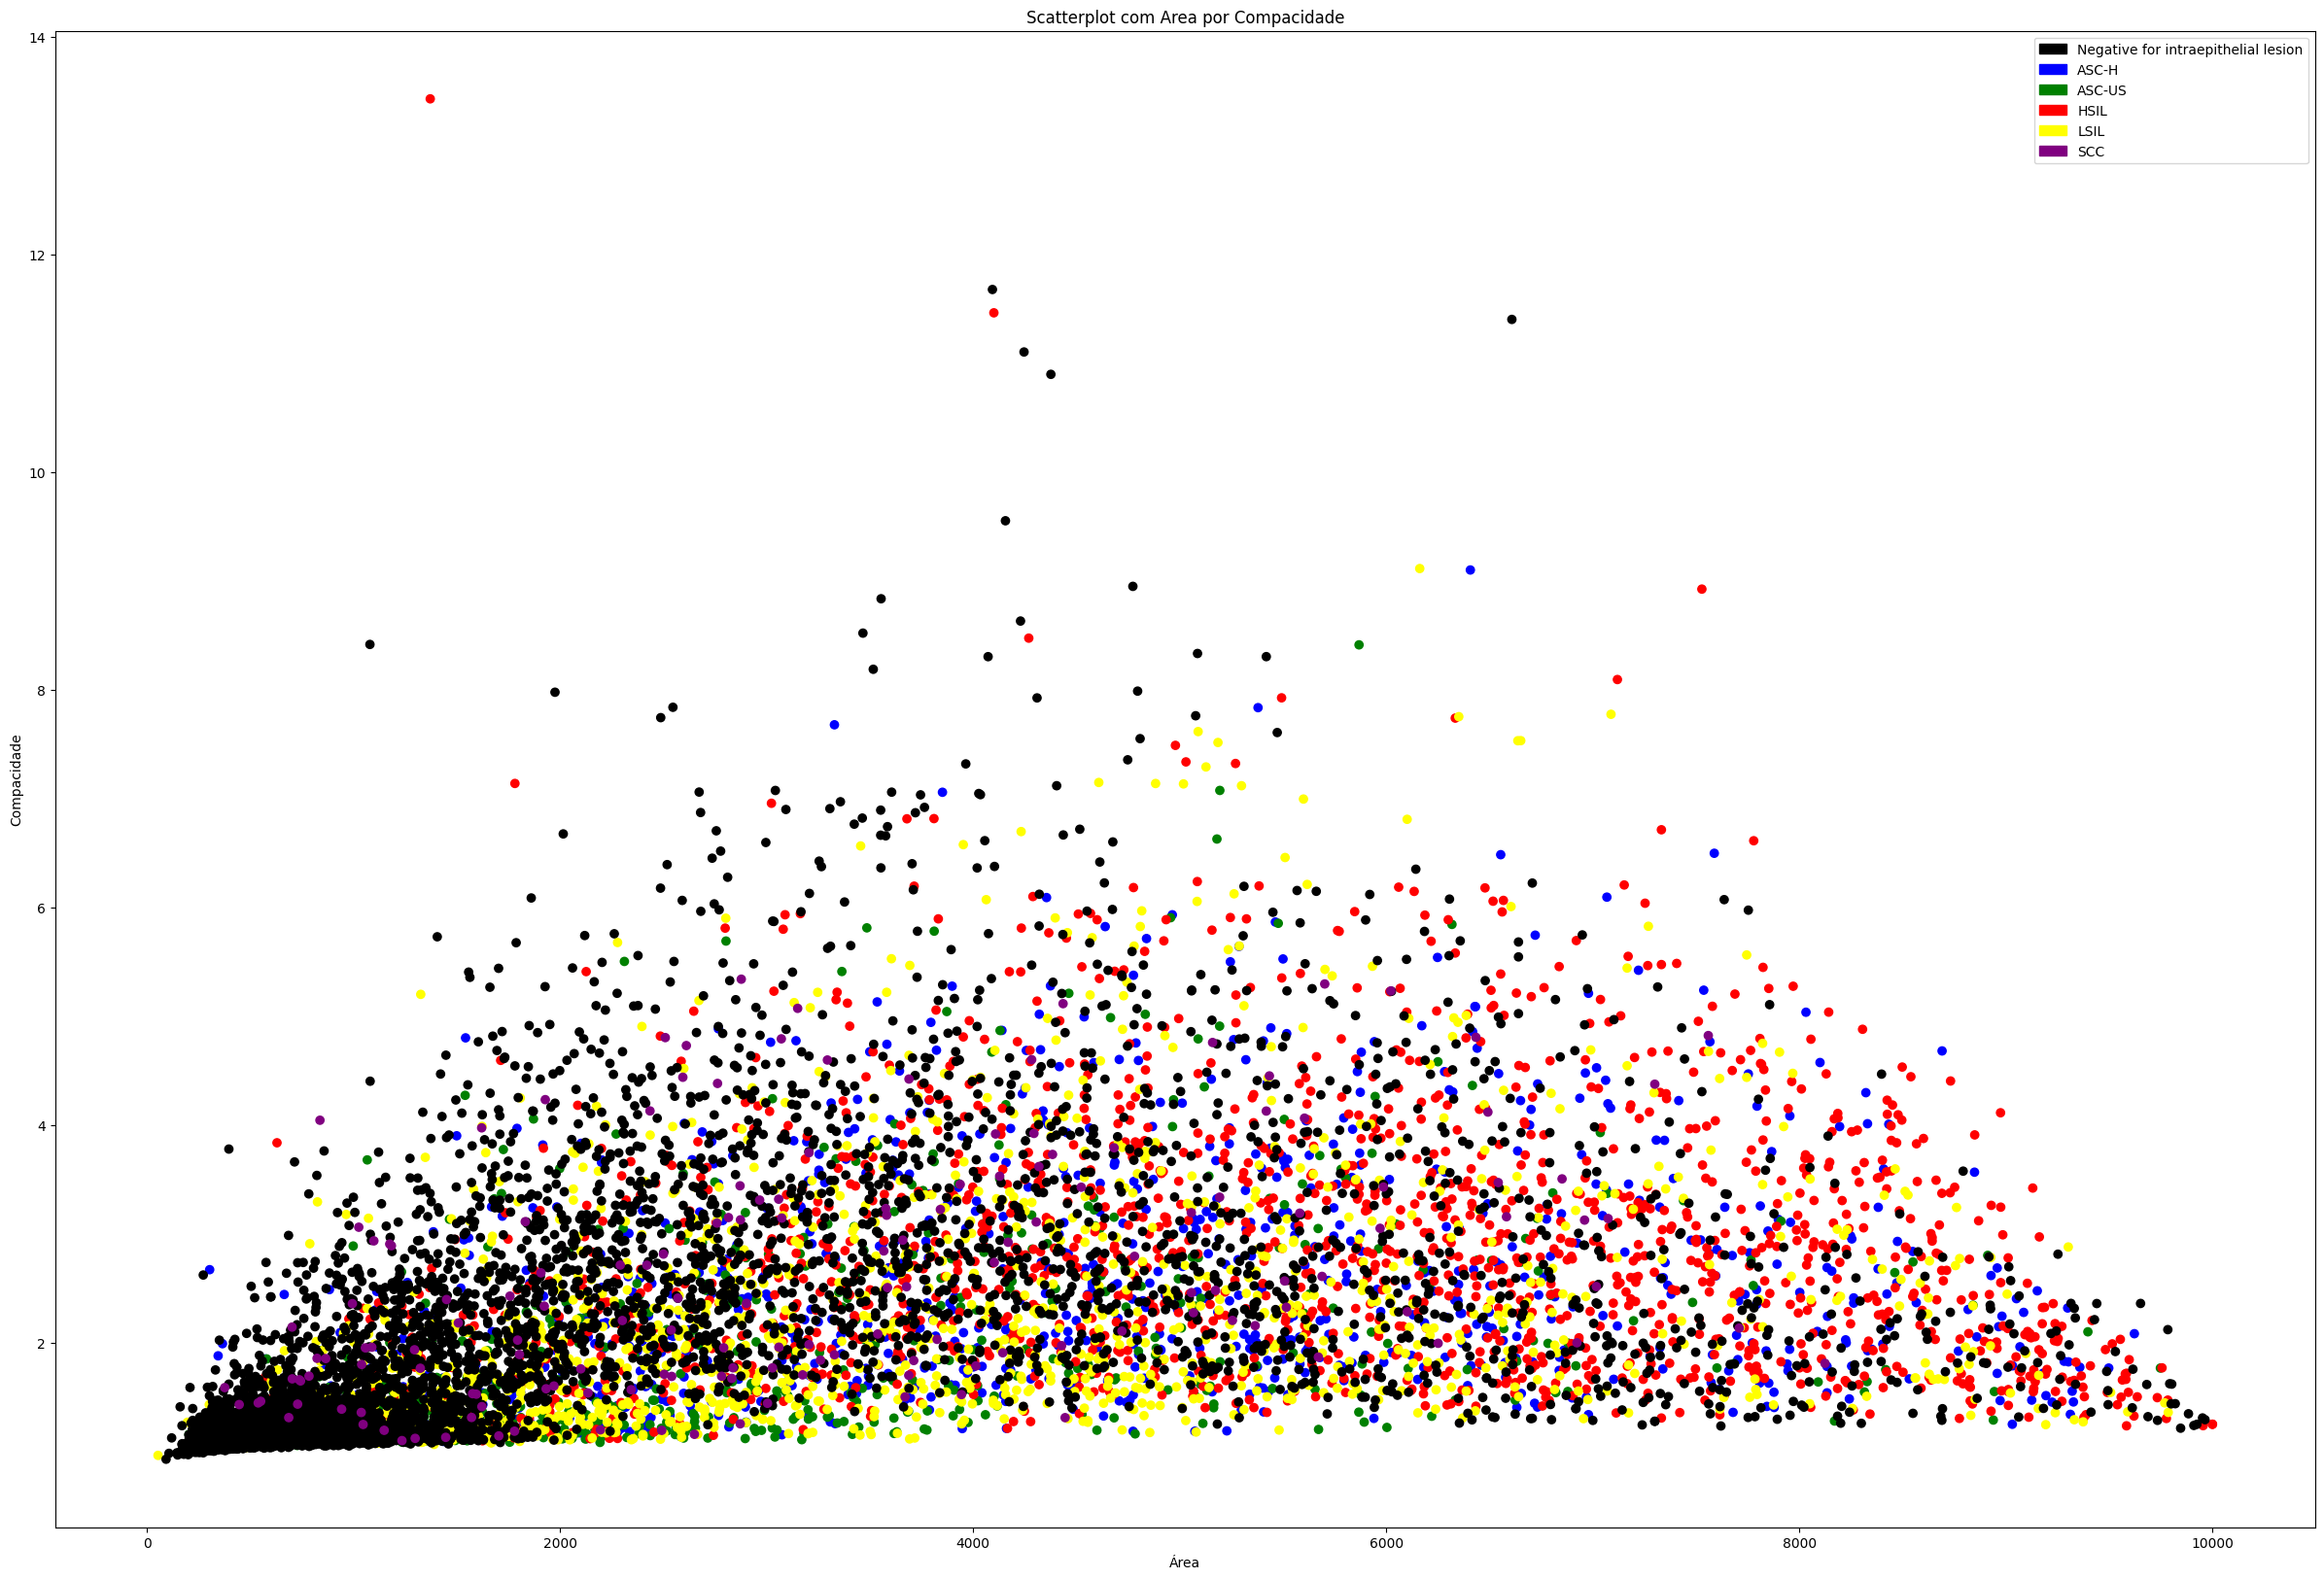

In [150]:
df = pd.read_csv('csv_pt2.csv')

cores = {'Negative for intraepithelial lesion': 'black', 'ASC-H': 'blue', "ASC-US":"green", 'HSIL': 'red', 'LSIL': 'yellow','SCC': 'purple',}

# Adicionar uma coluna 'Cor' com as cores correspondentes às classes
df['Cor'] = df['label'].map(cores)
plt.figure(figsize=(30, 20))

# Plotar o scatterplot
plt.scatter(df['area'], df['compacidade'], c=df['Cor'], label=df['label'])

# Tamanho da Figura

# Adicionar rótulos e título
plt.xlabel('Área')
plt.ylabel('Compacidade')
plt.title('Scatterplot com Area por Compacidade')

# Criando patches das legendas
patches = [mpatches.Patch(color=color, label=label) for label, color in cores.items()]

# Adicionar uma legenda
plt.legend(handles=patches)

# Exibir o gráfico
plt.show()

#### Area x Excentricidade

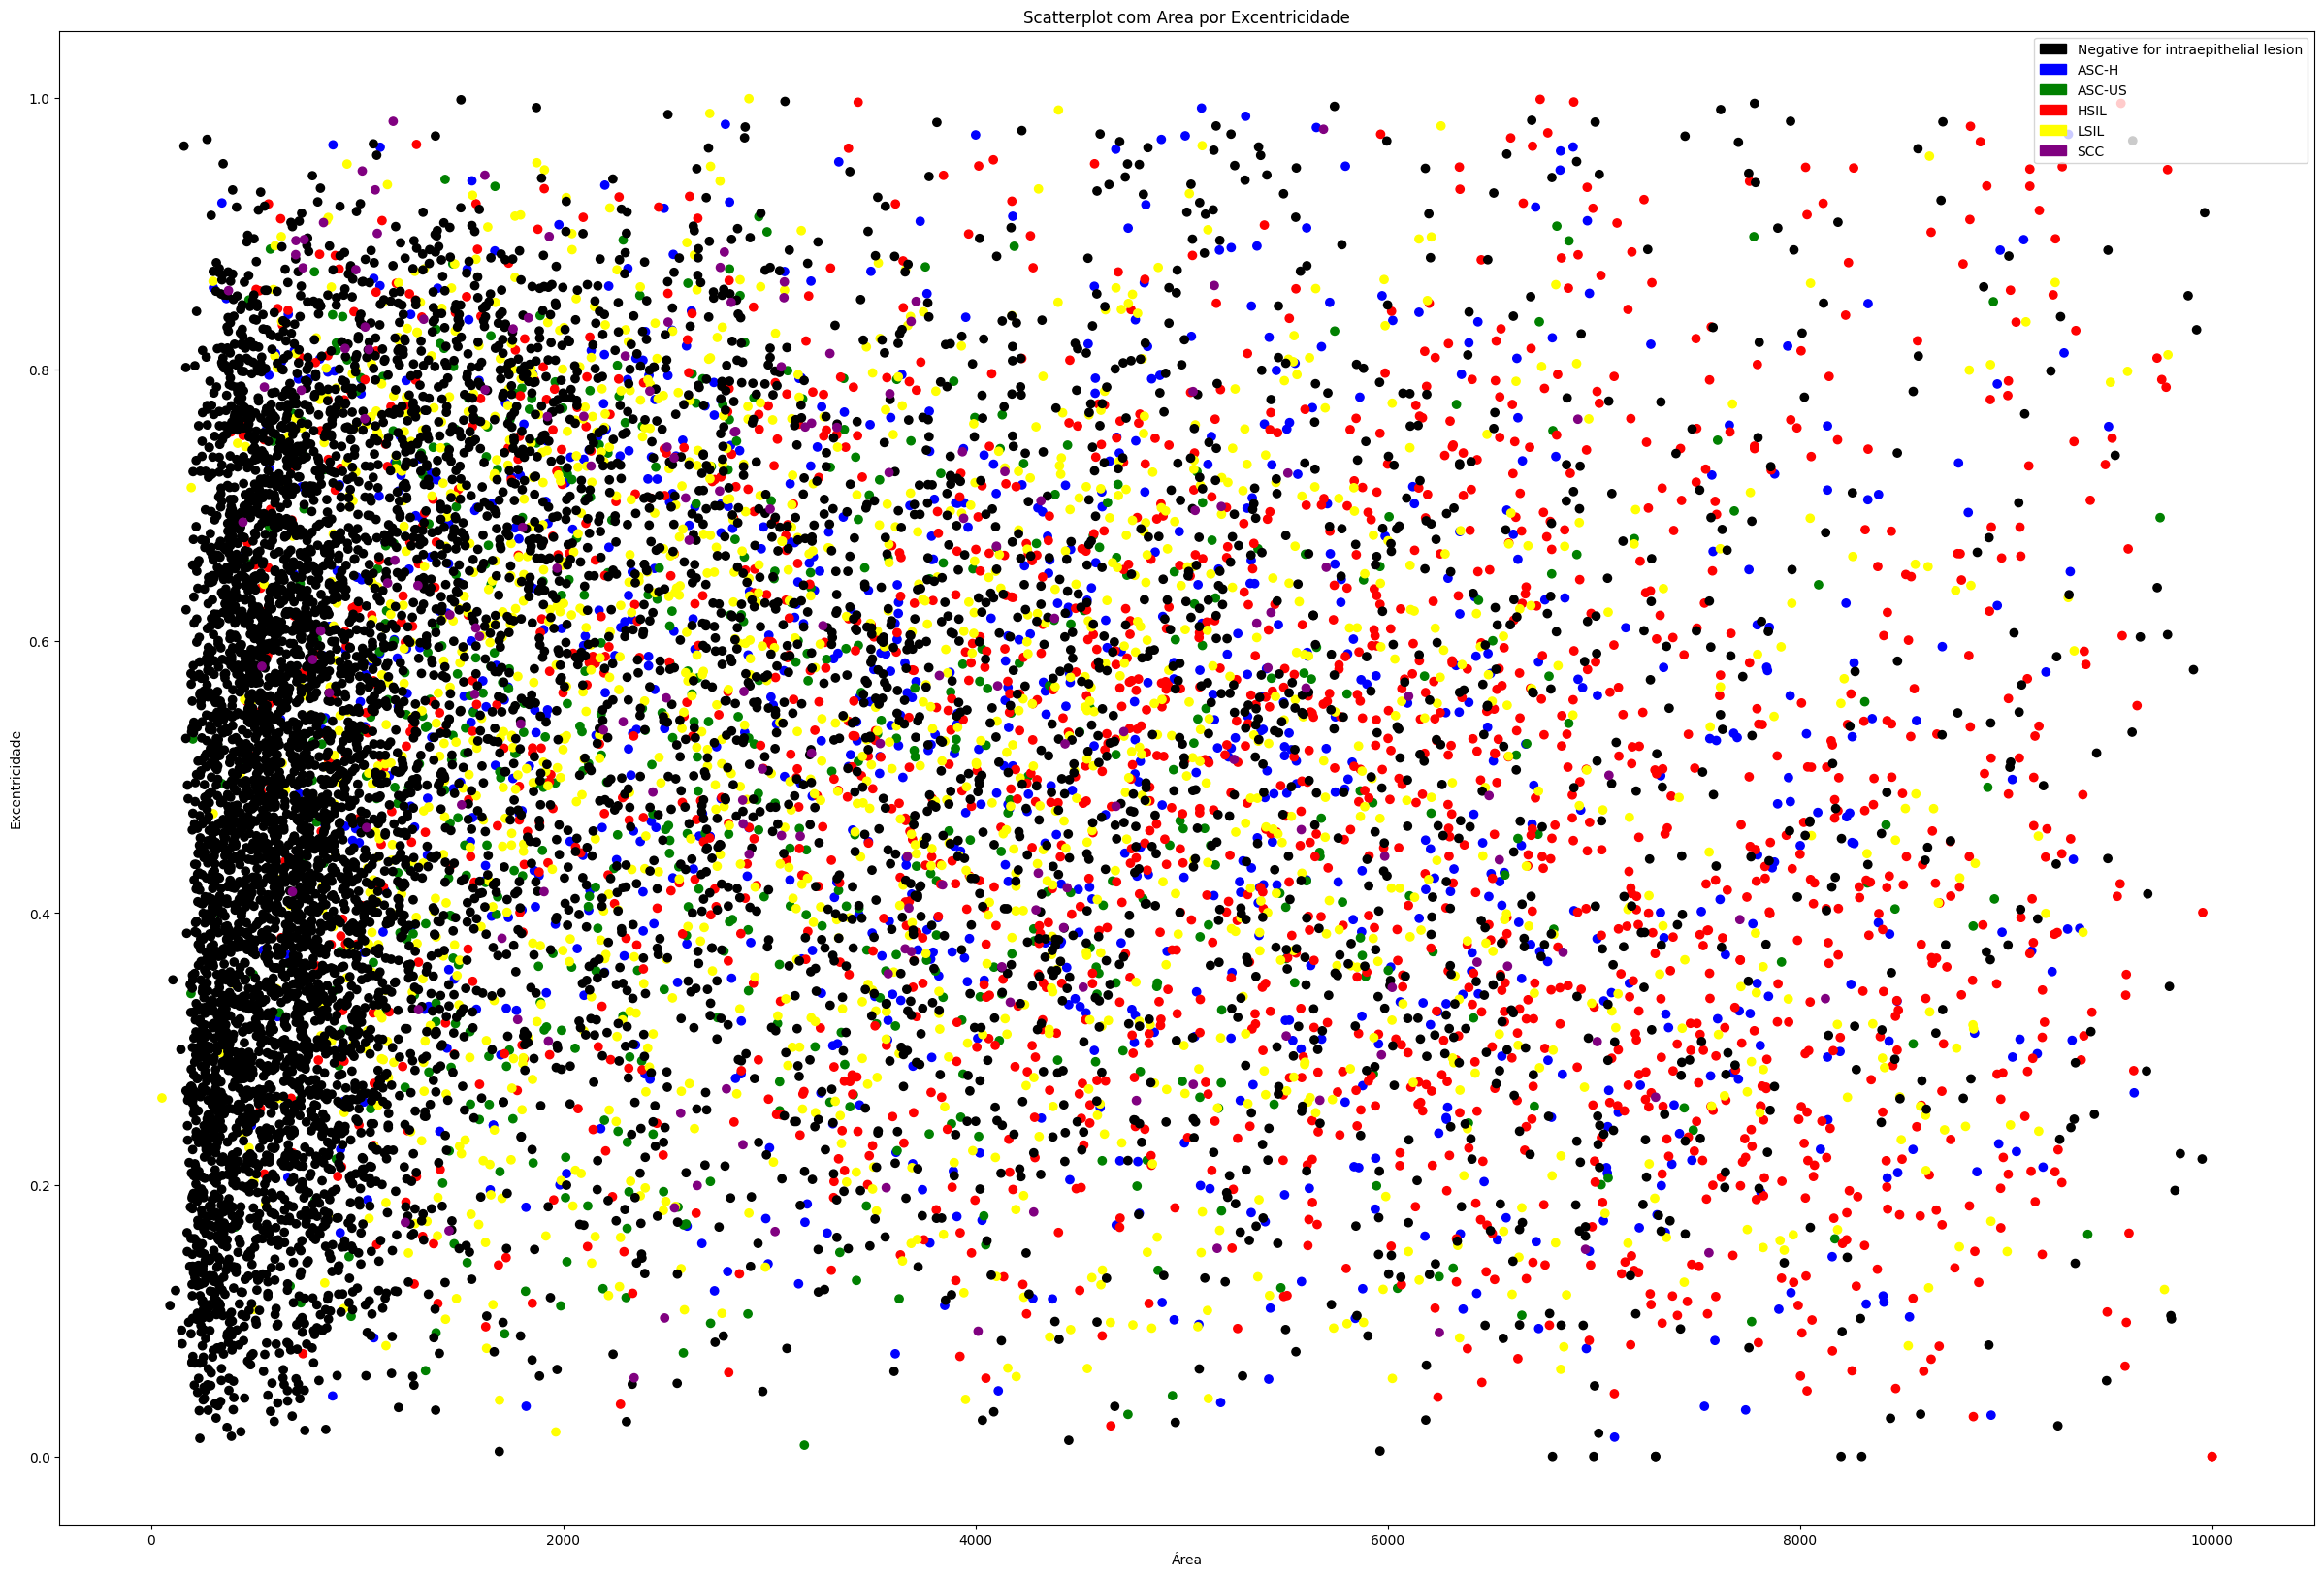

In [149]:
df = pd.read_csv('csv_pt2.csv')

# df_filter = df[df["excentricidade"]<10 ]
df_filter = df

cores = {'Negative for intraepithelial lesion': 'black', 'ASC-H': 'blue', "ASC-US":"green", 'HSIL': 'red', 'LSIL': 'yellow','SCC': 'purple',}

# Adicionar uma coluna 'Cor' com as cores correspondentes às classes
df_filter['Cor'] = df_filter['label'].map(cores)
plt.figure(figsize=(30, 20))

# Plotar o scatterplot
plt.scatter(df_filter['area'], df_filter['excentricidade'], c=df_filter['Cor'], label=df_filter['label'])

# Tamanho da Figura

# Adicionar rótulos e título
plt.xlabel('Área')
plt.ylabel('Excentricidade')
plt.title('Scatterplot com Area por Excentricidade')

# Criando patches das legendas
patches = [mpatches.Patch(color=color, label=label) for label, color in cores.items()]

# intervalos_y = [15, 25, 55, 115, 125, 155, 215, 225, 255, 315, 325, 355, 415, 425, 455, 515, 525, 555]
# plt.yticks(intervalos_y)
# Adicionar uma legenda
plt.legend(handles=patches)

# Exibir o gráfico
plt.show()

In [145]:
df[df["excentricidade"]>20 ]

,id_cel,label,area,compacidade,excentricidade,Cor
2244,8242,HSIL,6740,3.2329,30.93,red
4412,5559,LSIL,2901,2.2425,42.50,yellow
5569,11109,Negative for intraepithelial lesion,1504,1.8052,27.02,black


### Dividindo o dataset em treino e teste

In [ ]:
def obter_nomes_pastas(diretorio):
    nomes_pastas = []
    for nome in os.listdir(diretorio):
        if os.path.isdir(os.path.join(diretorio, nome)):
            nomes_pastas.append(nome)
    return nomes_pastas
  
  
# Exemplo de uso
cwd = os.getcwd()


diretorio = cwd + "/data/segmentation_dataset/"
pastas = obter_nomes_pastas(diretorio)

diretorio_origem = diretorio
diretorio_destino = cwd + '/data/segentation_dataset_treino/'

percent = 0.8

for each in pastas:

    # Diretório contendo todas as imagens
    diretorio_imagens = diretorio_origem + f'/{each}/'

    # Diretório para salvar as imagens de treinamento
    diretorio_treinamento = diretorio_destino + f'/train/{each}/'

    # Diretório para salvar as imagens de teste
    diretorio_teste = diretorio_destino + f'/test/{each}/'

    # Lista todas as imagens no diretório
    imagens = os.listdir(diretorio_imagens)

    # Embaralha a lista de imagens
    random.shuffle(imagens)

    # Calcula o índice para dividir as imagens
    indice_divisao = int(percent * len(imagens))

    # Separa as imagens em treinamento e teste
    imagens_treinamento = imagens[:indice_divisao]
    imagens_teste = imagens[indice_divisao:]

    if not (os.path.exists(diretorio_teste)):
        os.makedirs(diretorio_teste)

    if not (os.path.exists(diretorio_treinamento)):
        os.makedirs(diretorio_treinamento)

    # Move as imagens para os diretórios correspondentes
    for imagem in imagens_treinamento:
        shutil.copy(os.path.join(diretorio_imagens, imagem),
                    diretorio_treinamento)

    for imagem in imagens_teste:
        shutil.copy(os.path.join(diretorio_imagens, imagem), diretorio_teste)



### Calculando Mahalanobis 6 Classes

In [151]:
# Dividindo em treino e teste


df = pd.read_csv('./csv_pt2.csv')
train_df, test_df = train_test_split(df, test_size=0.8, random_state=42)


In [152]:
train_df

,id_cel,label,area,compacidade,excentricidade
1827,422,HSIL,6303,2.4282,0.762132
9154,5836,Negative for intraepithelial lesion,177,1.0632,0.494144
11162,917,Negative for intraepithelial lesion,1865,2.1853,0.554629
2376,8375,HSIL,4310,2.3152,0.390553
8551,4906,Negative for intraepithelial lesion,561,1.0596,0.221704
...,...,...,...,...,...
11284,9856,Negative for intraepithelial lesion,1066,1.0746,0.314158
5191,10728,Negative for intraepithelial lesion,434,1.0641,0.258914
5390,10934,Negative for intraepithelial lesion,881,1.0995,0.433458
860,9873,ASC-H,7675,2.7989,0.282206


In [163]:
def calcular_estatisticas_por_classe(df):
    estatisticas_por_classe = {}
    for classe in df['label'].unique():
        classe_df = df[df['label'] == classe]
        
        # Converta as colunas para números
        numeric_columns = ['area', 'compacidade', 'excentricidade']
        for col in numeric_columns:
            classe_df[col] = pd.to_numeric(classe_df[col], errors='coerce')
        
        estatisticas_por_classe[classe] = {
            'media': np.mean(classe_df[numeric_columns], axis=0),
            'covariancia': np.cov(classe_df[numeric_columns], rowvar=False)
        }
    return estatisticas_por_classe
# Calcule as estatísticas para o conjunto de treinamento
estatisticas_treinamento = calcular_estatisticas_por_classe(train_df)


for each in estatisticas_treinamento.items():
  print(each)

('HSIL', {'media': area              5202.710843
compacidade          2.729064
excentricidade       0.498272
dtype: float64, 'covariancia': array([[ 5.44289156e+06,  5.84176306e+02, -9.05845683e+01],
       [ 5.84176306e+02,  1.42828496e+00, -7.38569136e-02],
       [-9.05845683e+01, -7.38569136e-02,  4.80146372e-02]])})
('Negative for intraepithelial lesion', {'media': area              1864.353241
compacidade          1.865740
excentricidade       0.482589
dtype: float64, 'covariancia': array([[4.04599240e+06, 1.33185636e+03, 2.89676202e+01],
       [1.33185636e+03, 1.47197987e+00, 2.95909296e-02],
       [2.89676202e+01, 2.95909296e-02, 4.57935947e-02]])})
('LSIL', {'media': area              3714.318352
compacidade          2.228876
excentricidade       0.511861
dtype: float64, 'covariancia': array([[ 4.67879479e+06,  7.52686904e+02, -1.29058742e+02],
       [ 7.52686904e+02,  1.09212314e+00, -1.91868721e-02],
       [-1.29058742e+02, -1.91868721e-02,  4.39128695e-02]])})
('ASC-US'

C:\Users\Viny\AppData\Local\Temp\ipykernel_52200\955804924.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classe_df[col] = pd.to_numeric(classe_df[col], errors='coerce')
C:\Users\Viny\AppData\Local\Temp\ipykernel_52200\955804924.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classe_df[col] = pd.to_numeric(classe_df[col], errors='coerce')
C:\Users\Viny\AppData\Local\Temp\ipykernel_52200\955804924.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

Acurácia: 0.4811443433029909


<Axes: >

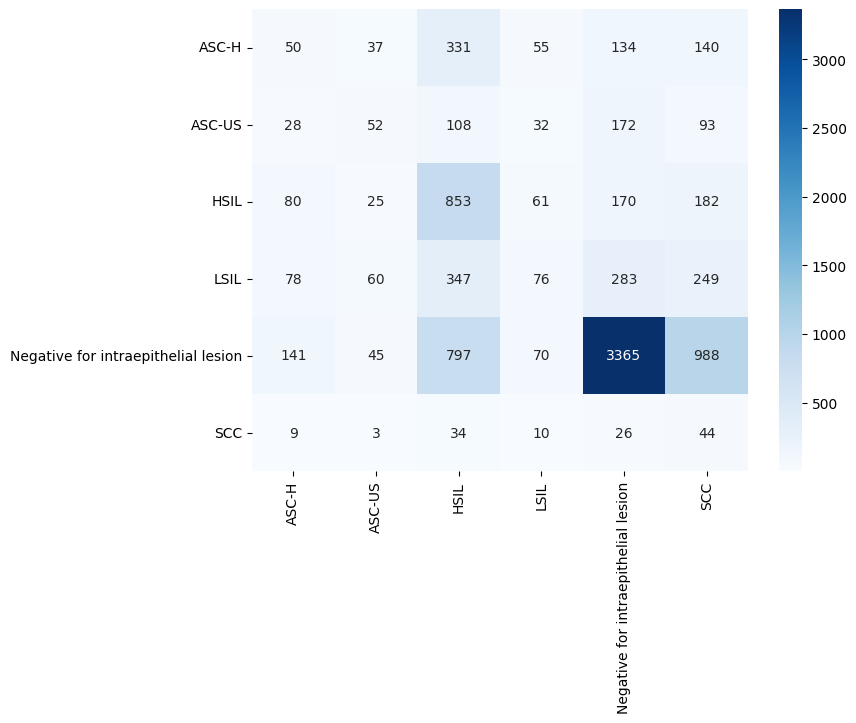

In [169]:
from scipy.spatial.distance import mahalanobis

# Função para classificar uma amostra usando distância de Mahalanobis
def classificar_mahalanobis(amostra, estatisticas_por_classe):
    distancias = {}
    for classe, estatisticas in estatisticas_por_classe.items():
        distancias[classe] = mahalanobis(amostra, estatisticas['media'], np.linalg.inv(estatisticas['covariancia']))
    return min(distancias, key=distancias.get)


test_df['predicao_mahalanobis'] = test_df[['area', 'compacidade', 'excentricidade']].apply(
    lambda x: classificar_mahalanobis(x, estatisticas_treinamento),
    axis=1
)


# Acurácia
acuracia = accuracy_score(test_df['label'], test_df['predicao_mahalanobis'])
print(f'Acurácia: {acuracia}')

# Matriz de Confusão
matriz_confusao = confusion_matrix(test_df['label'], test_df['predicao_mahalanobis'])
# print('Matriz de Confusão:')
# print(matriz_confusao)

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusao, annot=True, fmt='d', cmap='Blues', xticklabels=df['label'].unique(), yticklabels=df['label'].unique())

In [173]:
from scipy.spatial.distance import mahalanobis

# Função para classificar uma amostra usando distância de Mahalanobis
def classificar_mahalanobis(amostra, estatisticas_por_classe):
    distancias = {}
    for classe, estatisticas in estatisticas_por_classe.items():
        distancias[classe] = mahalanobis(amostra, estatisticas['media'], np.linalg.inv(estatisticas['covariancia']))
    return min(distancias, key=distancias.get)


test_df['predicao_mahalanobis'] = test_df[['area', 'compacidade', 'excentricidade']].apply(
    lambda x: classificar_mahalanobis(x, estatisticas_treinamento),
    axis=1
)


kf = KFold(n_splits=5, shuffle=True, random_state=42)
y_pred = cross_val_predict(
    estimator=None,  
    X=test_df[['area', 'compacidade', 'excentricidade']],  # Conjunto de teste
    y=test_df['label'],
    cv=kf,
    method=lambda x, estatisticas: classificar_mahalanobis(x, estatisticas),
    verbose=0,
    fit_params={'estatisticas': estatisticas_treinamento}
)


# Acurácia
acuracia = accuracy_score(train_df['label'], y_pred)
print(f'Acurácia: {acuracia}')

# Matriz de Confusão
# matriz_confusao = confusion_matrix(test_df['label'], test_df['predicao_mahalanobis'])
# # print('Matriz de Confusão:')
# # print(matriz_confusao)

# plt.figure(figsize=(8, 6))
# sns.heatmap(matriz_confusao, annot=True, fmt='d', cmap='Blues', xticklabels=df['label'].unique(), yticklabels=df['label'].unique())

TypeError: Cannot clone object 'None' (type <class 'NoneType'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.